# Data Correction for Germany

In this notebook I try to use the published number of weekly tests for germany to improve the prediction of the daily test counts.

Because I don't have access to the daily test data for germany I'm going to do the calculation on belgian data first.

In [1]:
# this cell makes it easier to mess with the project code interactively
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import logging
import numpy
import pandas
import pathlib
import matplotlib
from matplotlib import pyplot, cm

import arviz
import pymc3

_log = logging.getLogger('notebook')
logging.basicConfig(level=logging.INFO)

# messing with the path to get imports working
import sys
sys.path.append(str(pathlib.Path("..").resolve()))

import rtlive
from rtlive import data, preprocessing

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


Our first task is to get the weekly data for germany from ourworldindata.

In [3]:
from rtlive.sources import ourworldindata, data_de, data_be

In [4]:
run_time = pandas.Timestamp.today()
oiwd_data = ourworldindata.download_owid(run_time)
df = oiwd_data.xs('DE').xs('all')

The ourworldindata data does not contain continous data.

date
2020-03-08      124716.0
2020-03-15      252173.0
2020-03-22      600792.0
2020-03-29      962307.0
2020-04-05     1370655.0
2020-04-12     1750852.0
2020-04-19     2082754.0
2020-04-26     2446644.0
2020-05-03     2773432.0
2020-05-10     3177307.0
2020-05-17     3609383.0
2020-05-24     3963643.0
2020-05-31     4365232.0
2020-06-07     4702449.0
2020-06-14     5029645.0
2020-06-21     5415961.0
2020-06-28     5880587.0
2020-07-05     6387046.0
2020-07-12     6897597.0
2020-07-19     7436298.0
2020-07-26     7989727.0
2020-08-02     8576347.0
2020-08-09     9293115.0
2020-08-16    10128499.0
2020-08-23    11212945.0
2020-08-30    12333828.0
2020-09-06    13406144.0
2020-09-13    14571076.0
2020-09-20    15717641.0
2020-09-27    16873636.0
2020-10-04    17986603.0
2020-10-11    19174941.0
2020-10-18    20438657.0
2020-10-25    21857383.0
2020-11-01    23488726.0
2020-11-08    25096851.0
2020-11-15    26519152.0
2020-11-22    27913407.0
2020-11-29    29293266.0
2020-12-06    306408

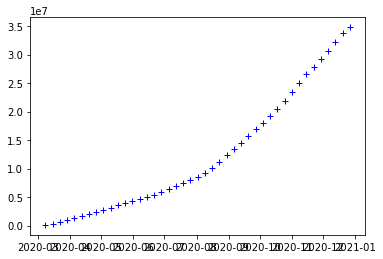

In [5]:
pyplot.plot(df.total_tests, 'b-+')
df.total_tests[~df.total_tests.isna()]

So we interpolate and calculate the diff to get the average daily test count in a week for each day.

The `limit_area` makes sure, that we only interpolate and don't extrapolate. Otherwise the reported test counts would be 0 instead of `NaN` for the not-yet-reported weeks.

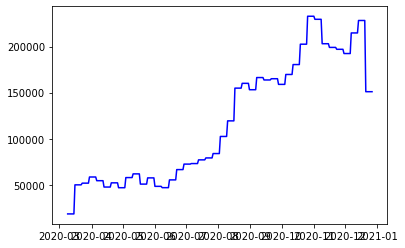

In [6]:
df_de_weekly_avg_per_day = df.total_tests.interpolate("linear", limit_area="inside").diff()
pyplot.plot(df_de_weekly_avg_per_day, 'b-')

This will be returned by the `data_de.get_testcounts_DE_weekly_average_per_day` Function.

If we calculate the cummulative sum of this data we get an interpolated version of the original data.

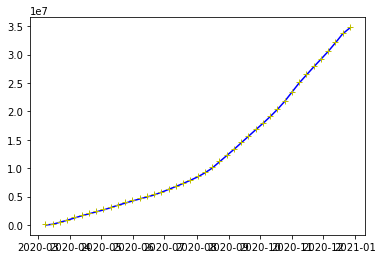

In [7]:
pyplot.plot(df_de_weekly_avg_per_day.cumsum(), 'b-')
pyplot.plot(df.total_tests, 'y+')

The same plot, but with belgian Data

In [8]:
df_be = oiwd_data.xs('BE').xs('all').total_tests

In [9]:
df_be_weekly = df_be.resample('W-Sun', level='date').last() #XXX: I don't know if the german data reported for sunday does include the data for sunday itself.
df_be_weekly.drop(df_be_weekly.tail(1).index,inplace=True) #Remove last row, because its an incomplete week in the future

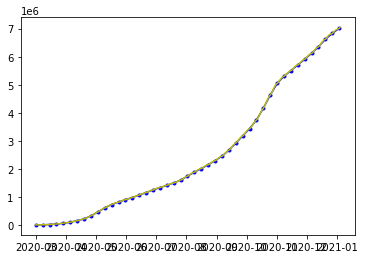

In [10]:
pyplot.plot(df_be_weekly, 'b.-')
pyplot.plot(df_be, 'y-')

The average tests per day per week then looks like this for Belgium:

In [11]:
df_be_weekly_avg_per_day = df_be_weekly.resample('D').interpolate("linear", limit_area="inside").diff()

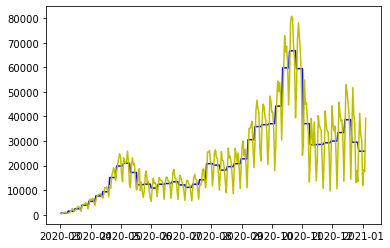

In [12]:
pyplot.plot(df_be_weekly_avg_per_day, 'b-') #The weekly averaged but daily data
pyplot.plot(df_be.diff(), 'y-') #the real daily data

First we predict the daily average data `df_be_weekly_avg_per_day`.

In [13]:
kwargs = dict(
                keep_data=True,
                growth="linear",
                ignore_before=pandas.Timestamp("2020-03-15") #XXX: In the original code there was a max:
                #max(
                    #pandas.Timestamp("2020-03-15"),
                    #df.xs(region)[~new_tests_nans].reset_index().date[0], #XXX
                #),
            )
results_be_weekly_avg_per_day = preprocessing.predict_testcounts(df_be_weekly_avg_per_day.reindex(pandas.date_range(start=df_be_weekly_avg_per_day.index[0], end=run_time + pandas.Timedelta('2W'), freq='D')), country='BE', region='all', **kwargs)

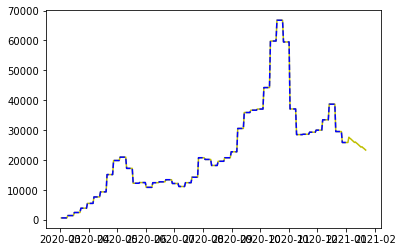

In [14]:
pyplot.plot(results_be_weekly_avg_per_day[0], 'y-') #the prediction
pyplot.plot(df_be_weekly_avg_per_day, 'b--') #the real daily data

Aaaaaannd.... the prediction does not look at all like i was hoping.

The same prediction for germany:

In [15]:
kwargs = dict(
                keep_data=True,
                growth="linear",
                ignore_before=pandas.Timestamp("2020-03-15") #XXX: In the original code there was a max:
                #max(
                    #pandas.Timestamp("2020-03-15"),
                    #df.xs(region)[~new_tests_nans].reset_index().date[0], #XXX
                #),
            )
results_de_weekly_avg_per_day = preprocessing.predict_testcounts(df_de_weekly_avg_per_day.reindex(pandas.date_range(start=df_de_weekly_avg_per_day.index[0], end=run_time + pandas.Timedelta('2W'), freq='D')), country='DE', region='all', **kwargs)

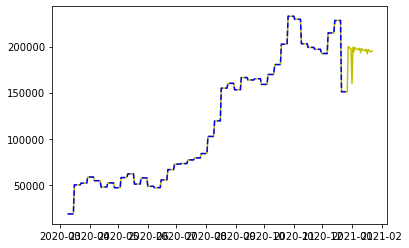

In [16]:
pyplot.plot(results_de_weekly_avg_per_day[0], 'y-') #the prediction
pyplot.plot(df_de_weekly_avg_per_day, 'b--') #the real data

Also does not look as expected.

Detour: Lets see, if calculating the factor for belgium and all its regions works.

In [17]:
df_be_regions = data_be.get_data_BE(run_time)

E:\Anaconda3\envs\rtlive\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'epistat.sciensano.be'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [18]:
df_be_regions

new_cases  new_tests
region date                            
ANT    2020-03-01          0         18
       2020-03-02          1         38
       2020-03-03          1        112
       2020-03-04          3        131
       2020-03-05          9        118
...                      ...        ...
all    2021-01-03       1009      17583
       2021-01-04       2031      40136
       2021-01-05       3393      59568
       2021-01-06       3216      54169
       2021-01-07        177       1844

[4382 rows x 2 columns]

In [19]:
df_be_regions['test_daily_factor'] = df_be_regions['new_tests'].divide(df_be_weekly_avg_per_day,level='date')

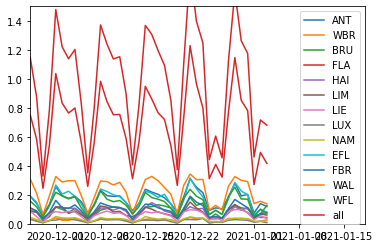

In [20]:
for region in df_be_regions.index.levels[0]:
    pyplot.plot(df_be_regions.loc[region]['test_daily_factor'],label=region)
pyplot.ylim(0,1.5)
pyplot.xlim(datetime.date.today() - datetime.timedelta(weeks=6))
pyplot.legend()

In [21]:
region = 'all'
kwargs = dict(
                keep_data=True,
                growth="linear",
                ignore_before=pandas.Timestamp("2020-03-15") #XXX: In the original code there was a max:
                #max(
                    #pandas.Timestamp("2020-03-15"),
                    #df.xs(region)[~new_tests_nans].reset_index().date[0], #XXX
                #),
            )
results_be_daily_factor = preprocessing.predict_testcounts(df_be_regions.xs(region).reindex(pandas.date_range(start=df_be_regions.index[0][1], end=run_time + pandas.Timedelta('2W'), freq='D'))['test_daily_factor'], country='BE', region=region, **kwargs)

(0.0, 2.0)

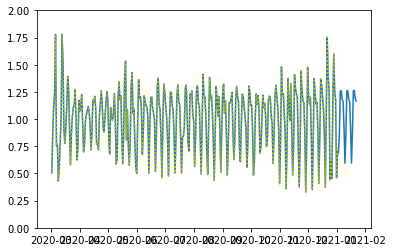

In [22]:
pyplot.plot(results_be_daily_factor[0])
pyplot.plot(df_be_regions.loc[region]['test_daily_factor'], 'y:')
pyplot.ylim(0,2)

The resulting prediction

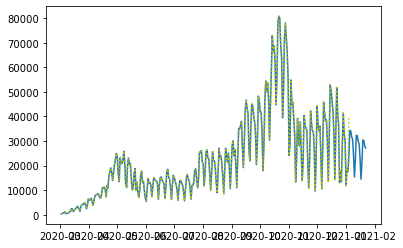

In [23]:
pyplot.plot(results_be_weekly_avg_per_day[0] * results_be_daily_factor[0])
pyplot.plot(df_be.diff(), 'y:')